In [1]:
%matplotlib inline

import os, sys
import numpy as np
import matplotlib.pyplot as plt

from good_action.utils import FUNC, ALGO
from good_action.functions import *


In [2]:

NUM_EXP = 10

INT_SPLIT = 10
BASE = int(200 // INT_SPLIT)

base_dir = './results'

def calc_cumu_query_stat_noiseless(func, acq, eps):
    datadir = os.path.join(base_dir, 'noiseless', FUNC[func], eps, ALGO[acq], func + '_' + acq +'_query_history.npy')
    total_queries = np.load(datadir, allow_pickle=True)[()]['queries']

    total_trials = len(total_queries) // NUM_EXP
    freq_sum = np.zeros((total_trials, INT_SPLIT+1))
    for j in range(total_trials):
        per_query = [x for x in total_queries[j*NUM_EXP:(j+1)*NUM_EXP] if x != 200]
        per_count = np.zeros(INT_SPLIT, dtype=int)
        for i, v in enumerate(per_query):
            interval = int(v//BASE)
            if v%BASE == 0 : interval -= 1
            per_count[interval] += 1
        per_freq = per_count/NUM_EXP
        freq_sum[j] = [np.sum(per_freq[:i]) for i in range(INT_SPLIT+1)]
    freq_mean = np.mean(freq_sum, axis=0)
    freq_std = np.std(freq_sum, axis=0)

    return freq_mean, freq_std


def calc_cumu_query_stat_noisy(func, acq, eps):
    datadir = os.path.join(base_dir, 'noisy', FUNC[func], eps, ALGO[acq], func + '_' + acq +'_query_history.npy')
    history = np.load(datadir, allow_pickle=True)[()]
    history_success = history['success']

    total_trials = len(history_success) // NUM_EXP
    success_stat = np.zeros((total_trials, NUM_EXP, INT_SPLIT+1))
    for j in range(total_trials):
        per_query = history_success[j*NUM_EXP:(j+1)*NUM_EXP]
        per_success = np.zeros(INT_SPLIT, dtype=int)
        for k in range(NUM_EXP):
            for i in range(INT_SPLIT):
                s = per_query[k][(i+1)*BASE - 1]
                success_stat[j,k,i+1] = s
    success_fraction_mean = np.mean(success_stat, axis=1)
    success_fraction_std = np.std(success_stat, axis=1)

    success_fraction_mean = np.mean(success_fraction_mean, axis=0)
    success_fraction_std = np.std(success_fraction_std, axis=0)
    return success_fraction_mean, success_fraction_std



In [3]:
plt.style.use('default')
import seaborn as sns

colors = sns.color_palette("dark")
greens = sns.color_palette("BuGn", 10)
blues = sns.color_palette("PuBu", 10)
reds = sns.color_palette("YlOrRd", 10)
purples = sns.color_palette("PuOr", 10)

FMT = {
        'gpucb' : 'x',
        'pi' : 's',
        'ei' : '^',
        'ts' : 'd',
        'mes' : '>',
        'pg' : 's',
        'eg' : '^',
        'sts' : 'd',
        'gs' : '>',
        }

COLOR = {
        'gpucb' : colors[5],
        'pi' : reds[-2],
        'ei' : blues[-2],
        'ts' : greens[-2],
        'mes' : purples[-2],
        'pg' : reds[-1],
        'eg' : blues[-1],
        'sts' : greens[-1],
        'gs' : purples[-1],
        }

LINE = {
        'gpucb' : '--',
        'pi' : '-',
        'ei' : '--',
        'ts' : ':',
        'mes' : '-.',
        'pg' : '-',
        'eg' : '--',
        'sts' : ':',
        'gs' : '-.',
        }


def plot(func, noisy, acq_list, eps, loc='lower right'):
    """
    Function for plotting the results
    
    func:      function name
    noisy:     True or False
    acq_list:  List of acq names
    eps:       good-action threshold
    """
    fig, ax = plt.subplots(figsize=(4.5, 3))
    freq_sum_xticks = []
    for i in range(INT_SPLIT+1):
        freq_sum_xticks.append(int(BASE*i))

    for acq in acq_list:
        if noisy:
            acq_mean, acq_std = calc_cumu_query_stat_noisy(func, acq, eps)
        else:
            acq_mean, acq_std = calc_cumu_query_stat_noiseless(func, acq, eps)

        ax.errorbar(range(INT_SPLIT+1), acq_mean, acq_std/2,\
                     fmt=FMT[acq], color=COLOR[acq], label=ALGO[acq],\
                    linestyle=LINE[acq], capsize=2, lw=1.5)

    ax.legend(loc=loc, fontsize='small')
    ax.set_ylim(-0.1,1.1)
    ax.set_xticks(range(INT_SPLIT+1))
    ax.set_xticklabels(freq_sum_xticks)
    ax.set_xlabel('Queries', fontsize=10)
    ax.set_ylabel('Success Fraction', fontsize=10)
    plt.show()
    # fig.savefig(base_dir + '\\%s.pdf'%(func), bbox_inches='tight')



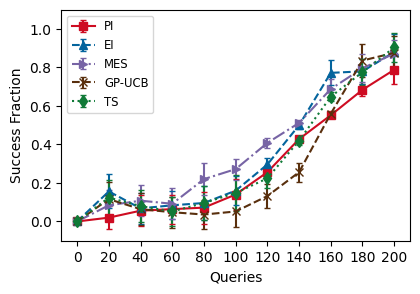

In [4]:
plot('keane', True, ['pi','ei','mes','gpucb','ts'], '0.85', 'upper left')

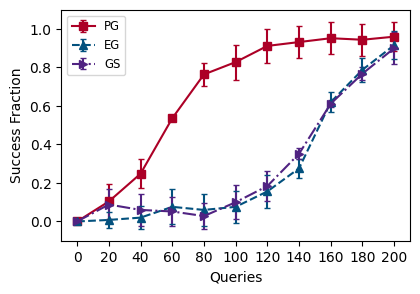

In [5]:
plot('keane', True, ['pg','eg','gs'], '0.85','upper left')

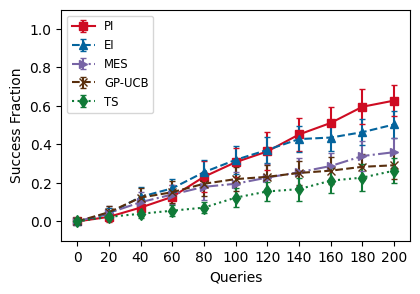

In [6]:
plot('robot4', False, ['pi','ei','mes','gpucb','ts'], '4.75', 'upper left')

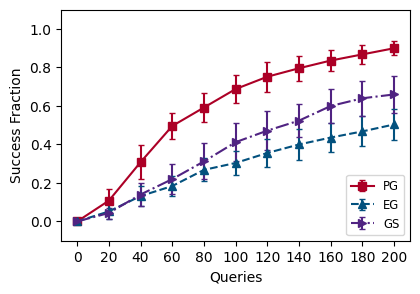

In [7]:
plot('robot4', False, ['pg','eg','gs'], '4.75', 'lower right')